In [18]:
import sys

sys.path.append("../")

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from machinelearning_control_fedbatch import grad, numpy_to_tensor
from system_ode_fedbatch import Fs, generate_data, get_volume

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda


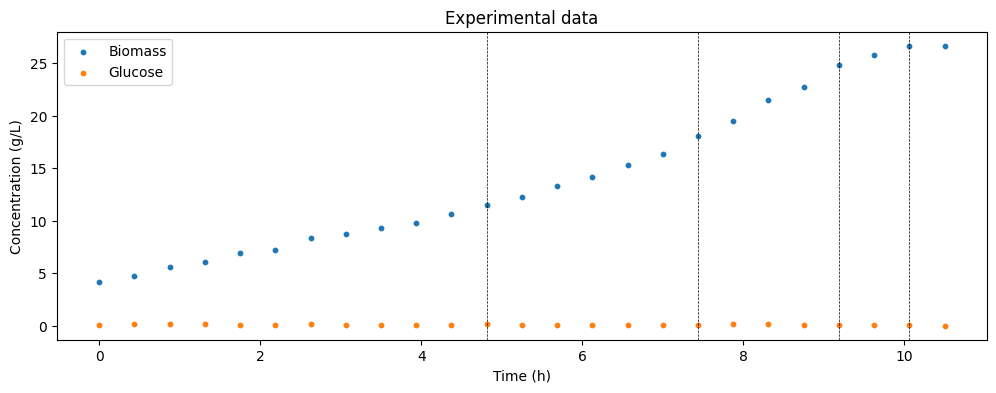

In [19]:
full_df = generate_data()

plt.figure(figsize=(12, 4))
plt.scatter(full_df["RTime"], full_df["Biomass"], s=10, label="Biomass")
plt.scatter(full_df["RTime"], full_df["Glucose"], s=10, label="Glucose")
for i in range(1, len(full_df)):
    if full_df["F"].iloc[i] != full_df["F"].iloc[i - 1]:
        plt.axvline(
            x=full_df["RTime"].iloc[i], color="black", linestyle="--", linewidth=0.5
        )
plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.title("Experimental data")
plt.show()

In [20]:
t_start = full_df['RTime'].min()
t_end = full_df['RTime'].max()
mu_max = 0.84
K_s = 0.2
Y_xs = 0.5
S_in = 1.43 * 200

In [21]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 64)
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 64)
        self.output = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)
        return x

In [22]:
def loss_fn(net: nn.Module, t_start: float, t_end: float, N_f: int):
    t_col = numpy_to_tensor(np.linspace(t_start, t_end, N_f))
    F_col = numpy_to_tensor([Fs(t) for t in t_col])
    V_col = numpy_to_tensor([get_volume(t) for t in t_col])
    
    preds = net.forward(t_col)  
    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    
    dXdt_pred = grad(X_pred, t_col)[0]
    dSdt_pred = grad(S_pred, t_col)[0]
    
    mu = mu_max * S_pred / (K_s + S_pred)
    
    error_dXdt = dXdt_pred - mu * X_pred + F_col / V_col * X_pred
    error_dSdt = dSdt_pred + mu * X_pred / Y_xs - F_col / V_col * (S_in - S_pred)
    
    error_ode = 0.5 * torch.mean(error_dXdt**2) + 0.5 * torch.mean(error_dSdt**2)
    return error_ode

In [23]:
NUM_EPOCHS = 30000
LEARNING_RATE = 1e-5
NUM_COLLOCATION = 1000
PATIENCE = 100
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1

def main(df: pd.DataFrame):
    
    t_train = numpy_to_tensor(df["RTime"].values)
    X_train = numpy_to_tensor(df["Biomass"].values)
    S_train = numpy_to_tensor(df["Glucose"].values)
    
    net = PINN(1, 2).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.7)
        
    w_data, w_ode, w_ic = 1.0, 1.0, 1.0
    
    # Initialize early stopping variables
    best_loss = float("inf")
    best_model_weights = None
    patience = PATIENCE
    threshold = THRESHOLD

    for epoch in range(NUM_EPOCHS):
        optimizer.zero_grad()
        preds = net.forward(t_train)
        X_pred = preds[:, 0].view(-1, 1)
        S_pred = preds[:, 1].view(-1, 1)
        error_X = torch.mean((X_train - X_pred)**2)
        error_S = torch.mean((S_train - S_pred)**2)
        loss_data = 0.5 * error_X + 0.5 * error_S
        loss_ode = loss_fn(net, t_start, t_end, NUM_COLLOCATION)
        loss = w_data * loss_data + w_ode * loss_ode
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % 100 == 0:
            print(
                f"Epoch {epoch}, Loss_data: {loss_data.item():.4f}, Loss_ode: {loss_ode.item():.4f}"
            )
            # Print the current learning rate of the optimizer
            for param_group in optimizer.param_groups:
                print("Current learning rate: ", param_group["lr"])

        if epoch >= EARLY_STOPPING_EPOCH:
            if loss < best_loss - threshold:
                best_loss = loss
                best_model_weights = copy.deepcopy(net.state_dict())
                patience = 1000
            else:
                patience -= 1
                if patience == 0:
                    print(f"Early stopping at epoch {epoch}")
                    net.load_state_dict(best_model_weights)
                    break
    
    return net

In [24]:
net = main(full_df.iloc[:1])

Epoch 0, Loss_data: 8.5326, Loss_ode: 14.3716
Current learning rate:  1e-05


Epoch 100, Loss_data: 8.1739, Loss_ode: 11.7471
Current learning rate:  1e-05
Epoch 200, Loss_data: 7.6489, Loss_ode: 8.1959
Current learning rate:  1e-05
Epoch 300, Loss_data: 6.7904, Loss_ode: 5.2873
Current learning rate:  1e-05
Epoch 400, Loss_data: 5.7592, Loss_ode: 4.1500
Current learning rate:  1e-05
Epoch 500, Loss_data: 4.7793, Loss_ode: 4.0319
Current learning rate:  1e-05
Epoch 600, Loss_data: 3.9095, Loss_ode: 4.0974
Current learning rate:  1e-05
Epoch 700, Loss_data: 3.0958, Loss_ode: 4.1124
Current learning rate:  1e-05
Epoch 800, Loss_data: 2.2606, Loss_ode: 4.0607
Current learning rate:  1e-05
Epoch 900, Loss_data: 1.3557, Loss_ode: 3.9926
Current learning rate:  1e-05
Epoch 1000, Loss_data: 0.6161, Loss_ode: 3.9547
Current learning rate:  1e-05
Epoch 1100, Loss_data: 0.2136, Loss_ode: 3.9083
Current learning rate:  1e-05
Epoch 1200, Loss_data: 0.0553, Loss_ode: 3.8681
Current learning rate:  1e-05
Epoch 1300, Loss_data: 0.0101, Loss_ode: 3.8322
Current learning rate:  

In [25]:
# pickle save the trained net
torch.save(net, "pinn_trained.pth")

In [28]:
# Predict
def evaluation(net: nn.Module, df: pd.DataFrame):
    t_pred = numpy_to_tensor(np.linspace(t_start, t_end, 1000))
    preds = net.forward(t_pred)
    X_pred = preds[:, 0].detach().cpu().numpy()
    S_pred = preds[:, 1].detach().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.scatter(df["RTime"], df["Biomass"], s=10, label="Biomass")
    plt.scatter(df["RTime"], df["Glucose"], s=10, label="Glucose")
    plt.plot(t_pred.detach().cpu().numpy(), X_pred, label="Biomass (pred)", color="red")
    plt.plot(t_pred.detach().cpu().numpy(), S_pred, label="Glucose (pred)", color="green")
    plt.xlabel("Time (h)")
    plt.ylabel("Concentration (g/L)")
    plt.legend()
    plt.title("Experimental data and prediction")
    plt.show()
    
    return X_pred, S_pred

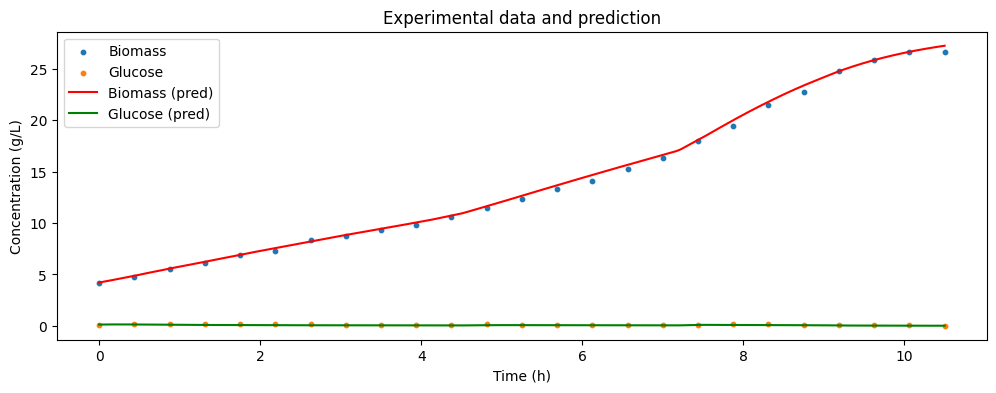

In [29]:
X_pred, S_pred = evaluation(net, full_df)